In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder

In [3]:
df_all = pd.read_csv('./all_donnees.csv')
df_alea = pd.read_csv('./donnees_aleatoires.csv')

In [4]:
le = LabelEncoder()
df_all['nom'] = le.fit_transform(df_all['nom'])
df_alea['nom'] = le.fit_transform(df_alea['nom'])

In [5]:
y_train= df_alea[['pourcentage_voix']].copy()
y_test = df_all[['pourcentage_voix']].copy()

X_train= df_alea[["part_pauvres_diff","part_modestes_diff","part_medians_diff","part_plutot_aises_diff",
                 "part_aises_diff","actemp","actcho","inactret","age_moyen","total_voix_par_ville","nom"
                 ,"insecurite","taux_chomage_moyen"]].copy()

X_test= df_all[["part_pauvres_diff","part_modestes_diff","part_medians_diff","part_plutot_aises_diff",
                 "part_aises_diff","actemp","actcho","inactret","age_moyen","total_voix_par_ville","nom"
                 ,"insecurite","taux_chomage_moyen"]].copy()

In [6]:
# Initialize the model
gbr = GradientBoostingRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_gradient = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_gradient.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search_gradient.best_params_)

# Best model
best_model_gradient = grid_search_gradient.best_estimator_

# Evaluate the model on the test set
y_pred_gradient = best_model_gradient.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gradient)
print(f"Test MSE: {mse}")

f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Test MSE: 10.631392974462036


In [7]:
r2 = r2_score(y_test, y_pred_gradient)
print(f"Test R2: {r2}")

Test R2: 0.8701801572942298


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import  KFold, GridSearchCV

In [9]:
"""
from keras.saving import register_keras_serializable
@register_keras_serializable()
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))
"""


'\nfrom keras.saving import register_keras_serializable\n@register_keras_serializable()\ndef r2_keras(y_true, y_pred):\n    SS_res = K.sum(K.square(y_true - y_pred))\n    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))\n    return (1 - SS_res / (SS_tot + K.epsilon()))\n'

In [10]:
"""
@register_keras_serializable()
def build_model(layers=[64, 32], input_dim=len(X_train)):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, activation='relu'))
    for layer in layers[1:]:
        model.add(Dense(layer, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), r2_keras])
    return model
"""

"\n@register_keras_serializable()\ndef build_model(layers=[64, 32], input_dim=len(X_train)):\n    model = Sequential()\n    model.add(Dense(layers[0], input_dim=input_dim, activation='relu'))\n    for layer in layers[1:]:\n        model.add(Dense(layer, activation='relu'))\n    model.add(Dense(1, activation='linear'))\n    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), r2_keras])\n    return model\n"

In [11]:
from keras_functions import r2_keras,build_model

In [12]:
scaler = StandardScaler()
X_train_neural = scaler.fit_transform(X_train).copy()
X_test_neural = scaler.transform(X_test).copy()

In [13]:
from scikeras.wrappers import KerasRegressor

In [14]:
input_dim = X_train_neural.shape[1]
# Wrapper for the Keras model
model = KerasRegressor(build_fn=build_model, input_dim=input_dim, epochs=100, batch_size=10, verbose=0, layers=[1])

# Define the parameter grid
param_grid = {
    'layers': [[64, 32], [128, 64, 32], [128, 64, 32, 16]],
    'batch_size': [10, 20],
    'epochs': [50, 100]
}

# Custom R2 scorer
r2_scorer = make_scorer(r2_score)

# Define the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=r2_scorer, cv=KFold(5))
grid_result = grid.fit(X_train_neural, y_train)


f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pa

In [15]:
# Best model parameters
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Predict with the best model on the test set
best_model_neural = grid_result.best_estimator_
y_pred_neural = best_model_neural.predict(X_test_neural)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred_neural)
r2 = r2_score(y_test, y_pred_neural)
print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")

Best: 0.8404368042945862 using {'batch_size': 10, 'epochs': 100, 'layers': [128, 64, 32, 16]}
Test MSE: 11.78227355628881
Test R2: 0.8561267852783203


In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
# Define the stacking regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('keras', best_model_neural),
        ('gb', best_model_gradient)
    ],
    final_estimator=LinearRegression()
)

# Train the stacking regressor
stacking_regressor.fit(X_train, y_train)

f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\ensemble\_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\scikeras\wrappers.py:925: UserW

StackingRegressor(estimators=[('keras',
                               KerasRegressor(batch_size=10, build_fn=<function build_model at 0x00000203657ECEA0>, epochs=100, input_dim=13, layers=[128, 64, 32, 16], verbose=0)),
                              ('gb',
                               GradientBoostingRegressor(max_depth=5,
                                                         min_samples_leaf=4,
                                                         subsample=0.8))],
                  final_estimator=LinearRegression())

In [17]:
# Predict with the stacking regressor
stacking_predictions = stacking_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, stacking_predictions)
r2 = r2_score(y_test, stacking_predictions)

print(f"Stacking Model Test MSE: {mse}")
print(f"Stacking Model Test R2: {r2}")

Stacking Model Test MSE: 10.659651709331735
Stacking Model Test R2: 0.8698350901403149


In [18]:

import joblib


best_model_neural.model_.save('./final_model/neural_network.keras')
with open('./final_model/gradient_bossting.pkl', 'wb') as f:
    joblib.dump(best_model_gradient, f)
# Save the stacking model
with open('./final_model/stacking_model.pkl', 'wb') as f:
    joblib.dump(stacking_regressor, f)






In [19]:
print(len(X_train))
print(len(X_test))

5415
56955


f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoost

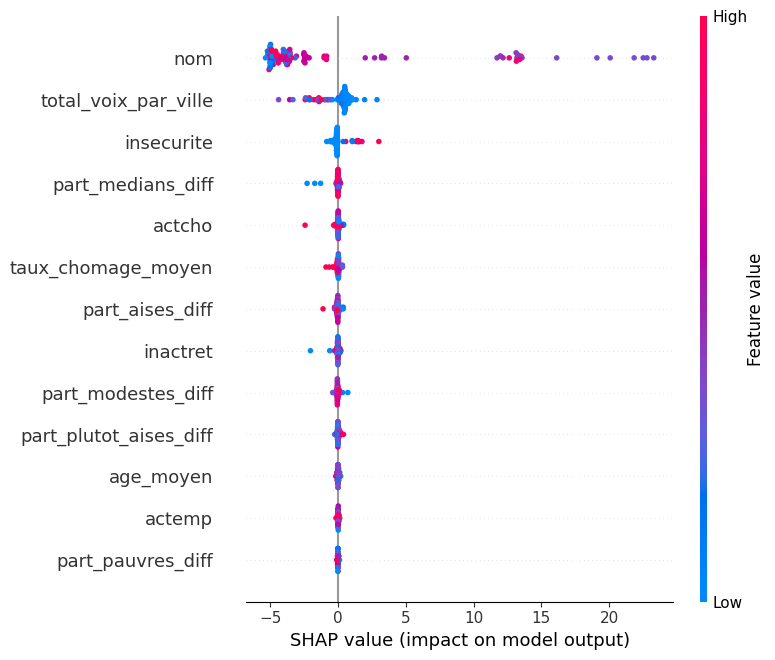

In [20]:
import shap
shap.initjs()
X_test_samples = X_test.sample(n=100)
X_train_samples = X_train.sample(n=100)
ex = shap.KernelExplainer(stacking_regressor.predict, data=X_train_samples)
shap_values = ex.shap_values(X_test_samples)
shap.summary_plot(shap_values, X_test_samples)

f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
f:\Developpement\MSPR-Analyse-de-donnees\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoost

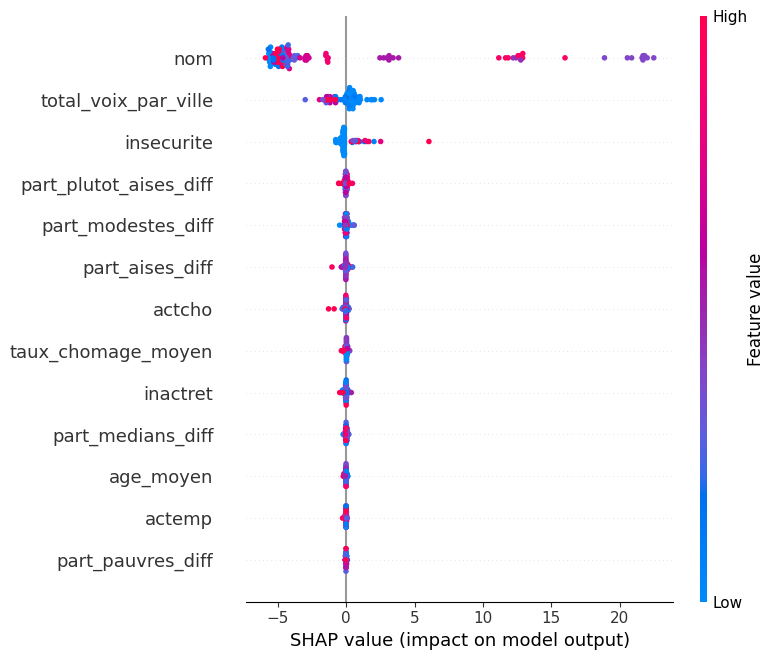

In [21]:
X_test_samples = X_test.sample(n=100)
X_train_samples = X_train.sample(n=500)
ex = shap.KernelExplainer(stacking_regressor.predict, data=X_train_samples)
shap_values = ex.shap_values(X_test_samples)
shap.summary_plot(shap_values, X_test_samples)